### Next Steps: Route Detection Using Color and Blob Analysis

Our goal is to identify climbing routes by detecting holds of the same color. We'll combine color analysis with blob detection to create a robust route identification system:

1. **Route-Based Color Analysis**
   - Each route is typically marked with holds of the same color
   - Different routes use distinct colors for clear differentiation
   - HSV color space will help isolate specific route colors
   - Create separate masks for each route color

2. **Blob Detection for Hold Identification**
   - Use SimpleBlobDetector to find hold-like shapes within color masks
   - Configure detection parameters specific to climbing holds:
     - Size ranges for typical hold dimensions
     - Shape characteristics (circularity, convexity)
   - Group detected blobs by color to identify route sequences

3. **Route Analysis Implementation**
   - Convert images to HSV for better color separation
   - Create individual masks for each route color
   - Apply blob detection within each color mask
   - Connect holds of the same color to identify complete routes
   - Calculate route properties (difficulty, path, spacing)

4. **Expected Benefits**
   - Automatic route identification and separation
   - Clear visualization of different climbing paths
   - Potential for route difficulty analysis
   - Ability to track route changes over time
   - Support for route-setting documentation

5. **Potential Challenges**
   - Distinguishing between routes with similar colors
   - Handling routes that cross or overlap
   - Dealing with holds that span multiple colors
   - Accounting for varying lighting conditions
   - Managing missing or obscured holds

By focusing on color-based route detection enhanced by blob analysis, we can create a system that not only identifies individual holds but understands their relationship within specific climbing routes.

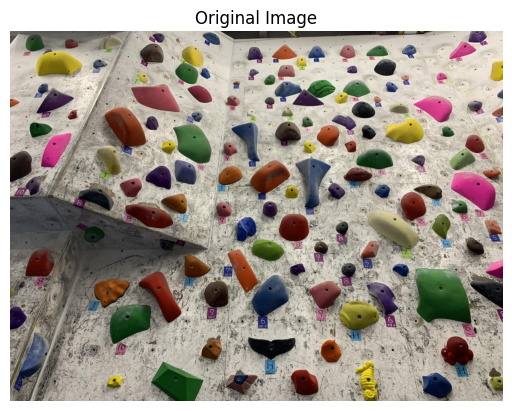

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv2.imread('immagini test/IMG_006.jpg')
image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.axis('off')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()


Todo: l'aggiunta di brightness l'abbiamo implementata successivamente per migliorare i risultati di color detection (es: il verde viene detectato slightly better)

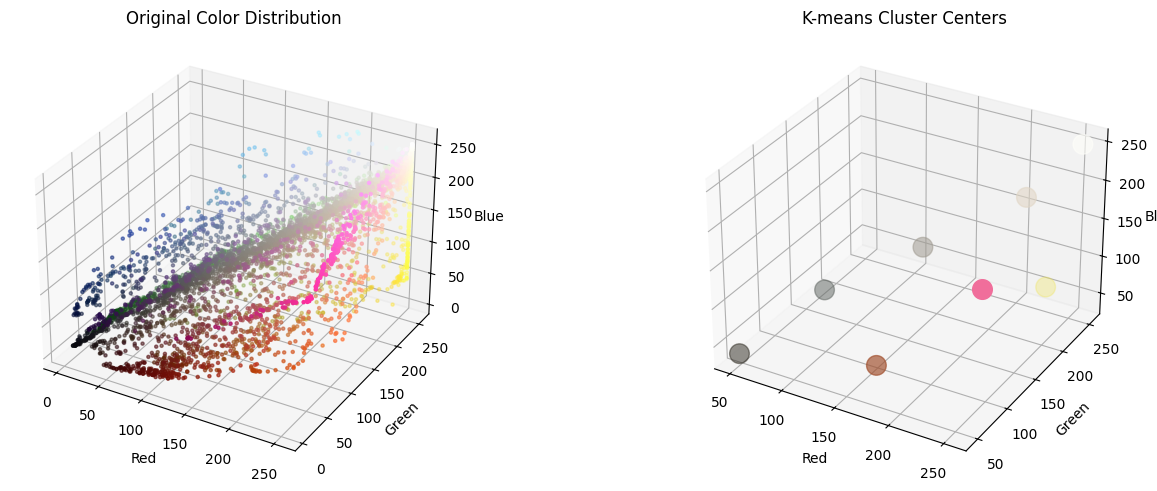

In [30]:
# Apply Gaussian blur to reduce noise
image_blurred = cv2.GaussianBlur(image, (5,5), 0)

# Apply median blur to further reduce noise while preserving edges
image_blurred = cv2.medianBlur(image_blurred, 31)

# Highlight colors and increase contrast
image_blurred = cv2.convertScaleAbs(image_blurred, alpha=1.5, beta=0)

# Convert blurred image to grayscale for blob detection
image_grey = cv2.cvtColor(image_blurred, cv2.COLOR_BGR2GRAY)

# Display the three images
plt.figure(figsize=(25, 9))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(image_blurred, cv2.COLOR_BGR2RGB))
plt.title('Blurred Image')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(cv2.cvtColor(image_blurred, cv2.COLOR_BGR2RGB))
plt.title('Enhanced Image')
plt.axis('off')

plt.show()

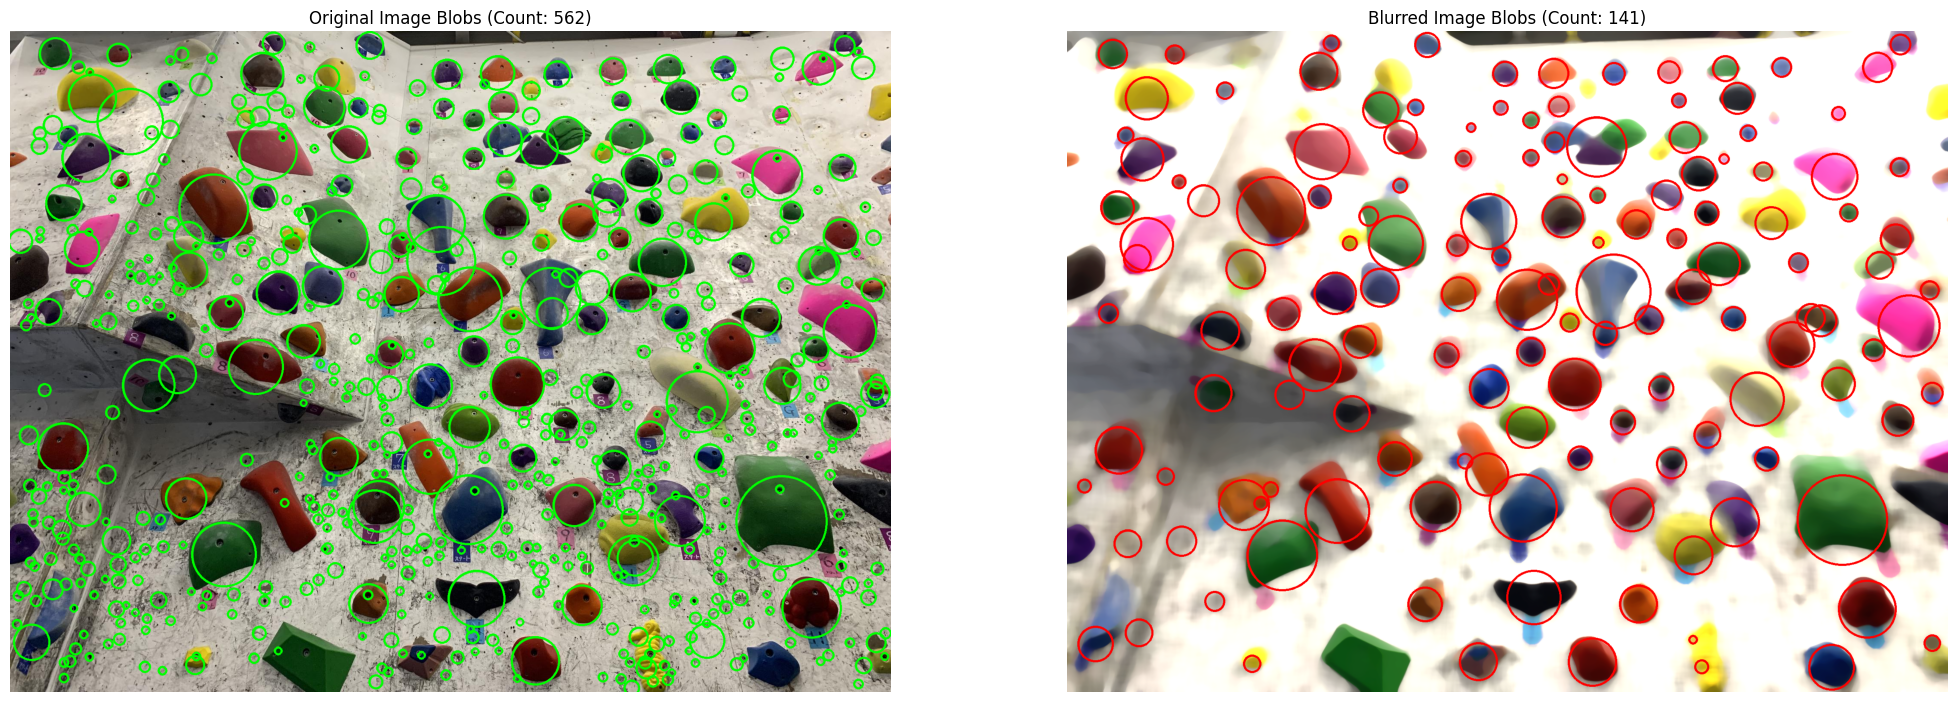

In [26]:
# Set up blob detector parameters
params = cv2.SimpleBlobDetector_Params()

# Modify area parameters to also detect larger holds
params.filterByArea = True
params.minArea = 100
params.maxArea = 150000

# Modify other parameters for better detection
params.filterByCircularity = False
params.filterByConvexity = False
params.filterByInertia = False

# Create detector
detector = cv2.SimpleBlobDetector_create(params)

# Detect blobs on original grayscale image
keypoints_orig = detector.detect(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

# Detect blobs on blurred grayscale image 
keypoints_blurred = detector.detect(image_grey)

# Draw keypoints on original image
img_with_keypoints_orig = cv2.drawKeypoints(
    image.copy(), 
    keypoints_orig,
    np.array([]),
    (0, 255, 0),  
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS | cv2.DRAW_MATCHES_FLAGS_DEFAULT
)

# Draw additional circles on original
for keypoint in keypoints_orig:
    x = int(keypoint.pt[0])
    y = int(keypoint.pt[1]) 
    r = int(keypoint.size/2)
    cv2.circle(img_with_keypoints_orig, (x, y), r+2, (0, 255, 0), 4)

# Draw keypoints on blurred image
img_with_keypoints_blurred = cv2.drawKeypoints(
    image_blurred.copy(),
    keypoints_blurred, 
    np.array([]),
    (0, 0, 255),  
    cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS | cv2.DRAW_MATCHES_FLAGS_DEFAULT
)

# Draw additional circles on blurred
for keypoint in keypoints_blurred:
    x = int(keypoint.pt[0])
    y = int(keypoint.pt[1])
    r = int(keypoint.size/2)
    cv2.circle(img_with_keypoints_blurred, (x, y), r+2, (0, 0, 255), 4)

# Display results
plt.figure(figsize=(25, 12))

plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_with_keypoints_orig, cv2.COLOR_BGR2RGB))
plt.title(f'Original Image Blobs (Count: {len(keypoints_orig)})')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_with_keypoints_blurred, cv2.COLOR_BGR2RGB))
plt.title(f'Blurred Image Blobs (Count: {len(keypoints_blurred)})')
plt.axis('off')

plt.show()

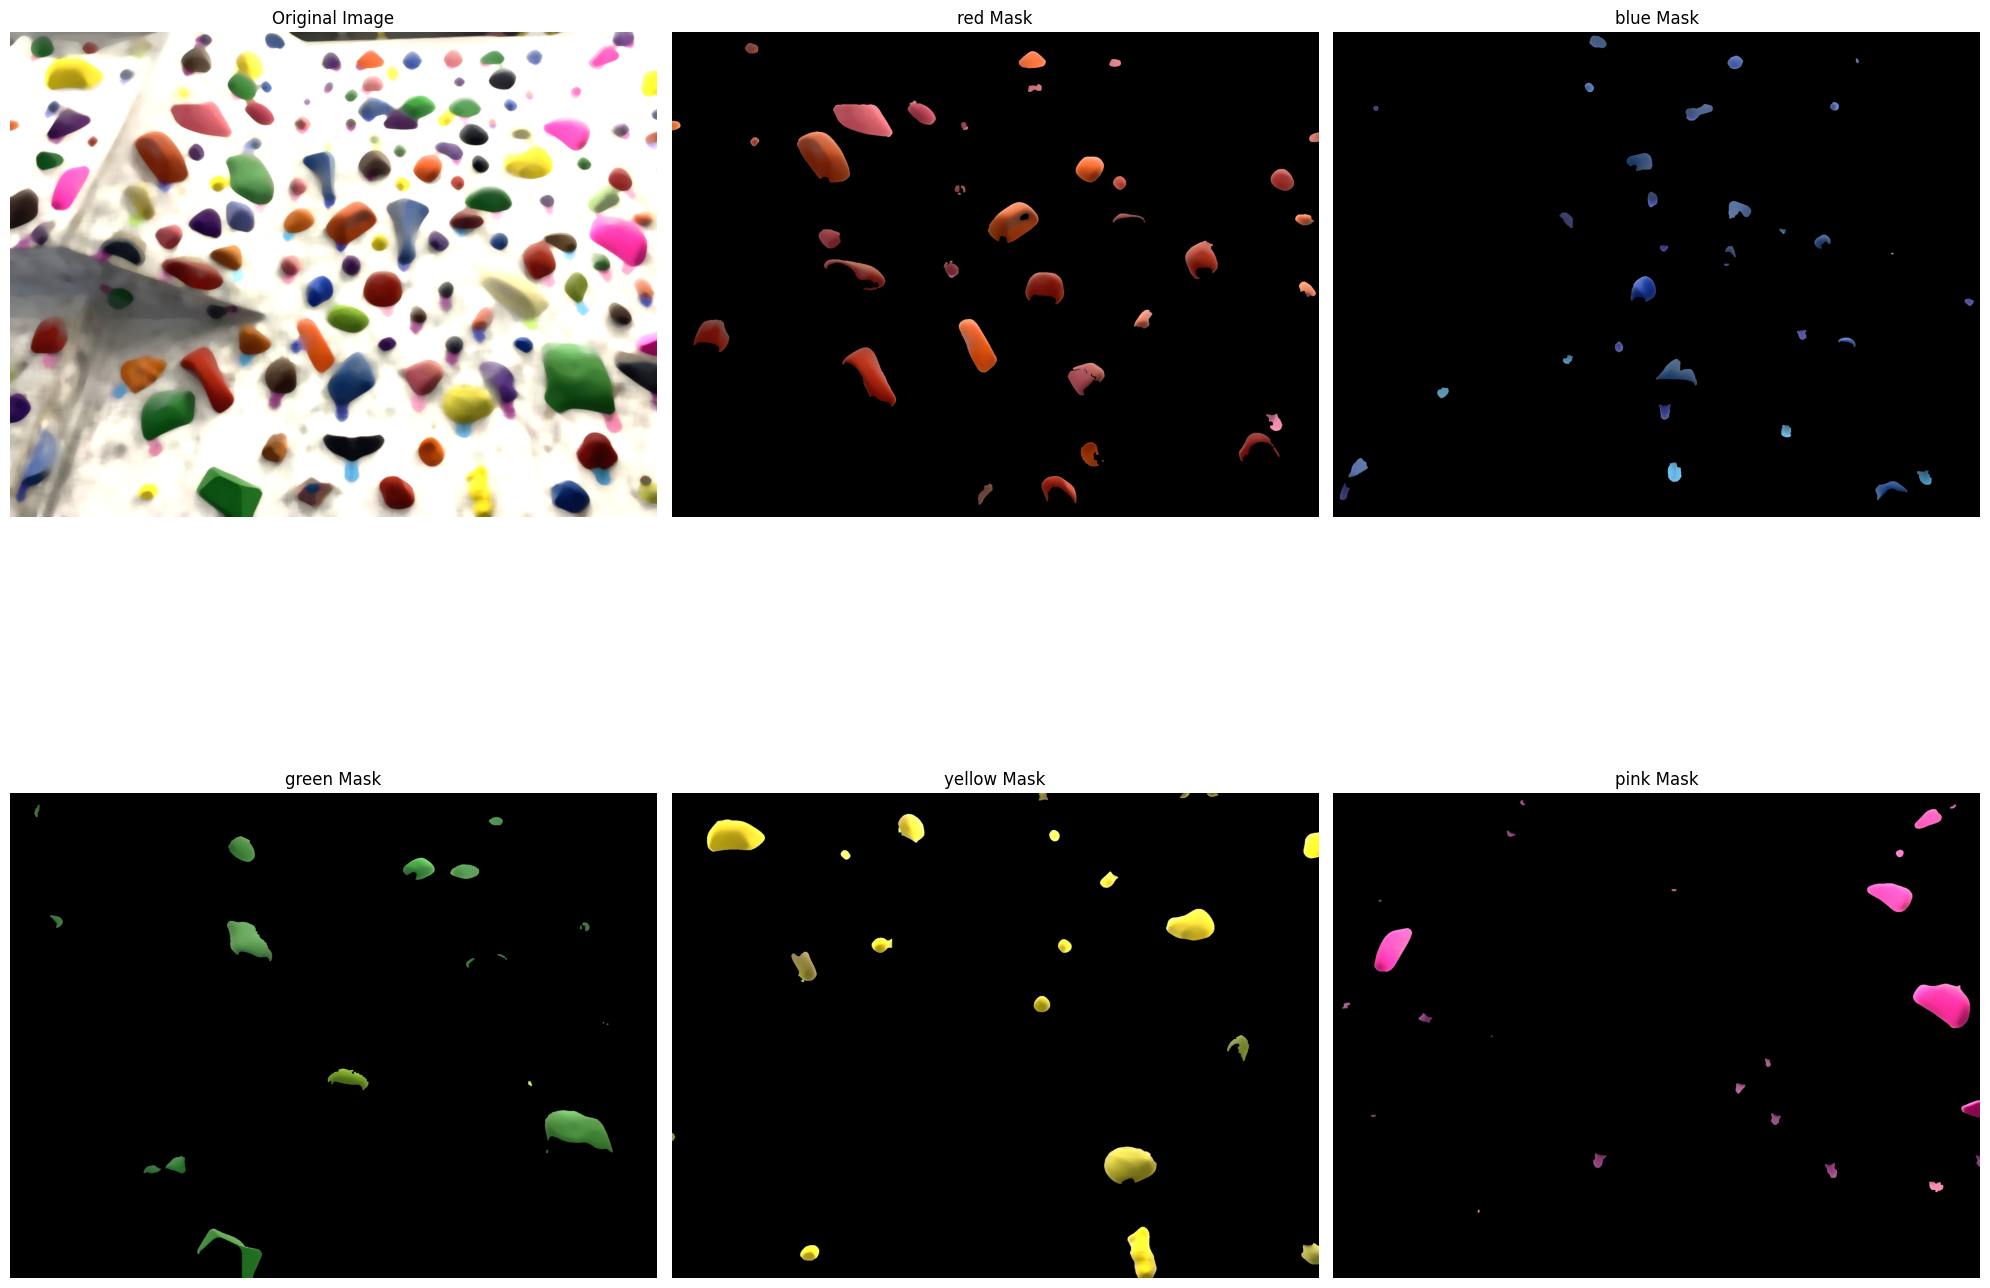

In [27]:
import cv2
import numpy as np

# Create a mask for a specific color range in HSV space
def create_color_mask(image, color_range):
    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Create mask using the color range
    mask = cv2.inRange(hsv, color_range[0], color_range[1])
    
    # Denoise the mask
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

# Define color ranges in HSV
color_ranges = {
    'red1': (np.array([0, 100, 100]), np.array([10, 255, 255])),     # Red has two ranges in HSV
    'red2': (np.array([170, 100, 100]), np.array([180, 255, 255])),  # due to how hue wraps around
    'blue': (np.array([100, 100, 100]), np.array([130, 255, 255])),
    'green': (np.array([40, 100, 100]), np.array([80, 255, 255])),
    'yellow': (np.array([20, 100, 100]), np.array([35, 255, 255])),
    'pink': (np.array([150, 100, 100]), np.array([170, 255, 255])),
}

# Process image for each color
def detect_colored_holds(image, color_name, color_range):
    """
    Detect holds of a specific color
    """
    # Create mask for this color
    mask = create_color_mask(image, color_range)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours based on area
    min_area = 100
    max_area = 15000
    valid_contours = [cnt for cnt in contours if min_area < cv2.contourArea(cnt) < max_area]
    
    # Draw results
    result = image.copy()
    cv2.drawContours(result, valid_contours, -1, (0, 255, 0), 2)
    
    return result, mask, valid_contours

# Example usage
def analyze_routes(image):
    # Calculate number of subplots needed (original + all colors except red2)
    n_colors = len(color_ranges) - 1  # Subtract 1 because red1 and red2 are combined
    n_rows = (n_colors + 1) // 3 + 1  # Add 1 to account for original image
    n_cols = 3
    
    plt.figure(figsize=(20, 8 * n_rows))
    
    # Original image
    plt.subplot(n_rows, n_cols, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')
    
    # Process each color
    plot_idx = 2  # Start from second subplot
    for color_name, color_range in color_ranges.items():
        if color_name == 'red2':  # Skip red2 as it's combined with red1
            continue
            
        if color_name == 'red1':  # Combine red1 and red2 masks
            mask1 = create_color_mask(image, color_ranges['red1'])
            mask2 = create_color_mask(image, color_ranges['red2'])
            mask = cv2.bitwise_or(mask1, mask2)
            result, _, contours = detect_colored_holds(image, 'red', color_ranges['red1'])
            color_display_name = 'red'
        else:
            result, mask, contours = detect_colored_holds(image, color_name, color_range)
            color_display_name = color_name
        
        # Create masked image showing original colors where mask is true
        masked_image = image.copy()
        masked_image[mask == 0] = 0  # Set background to black
        
        # Show masked original image
        plt.subplot(n_rows, n_cols, plot_idx)
        plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
        plt.title(f'{color_display_name} Mask')
        plt.axis('off')
        plot_idx += 1
    
    plt.tight_layout()
    plt.show()
    
    return result

# Run the analysis
result = analyze_routes(image_blurred)

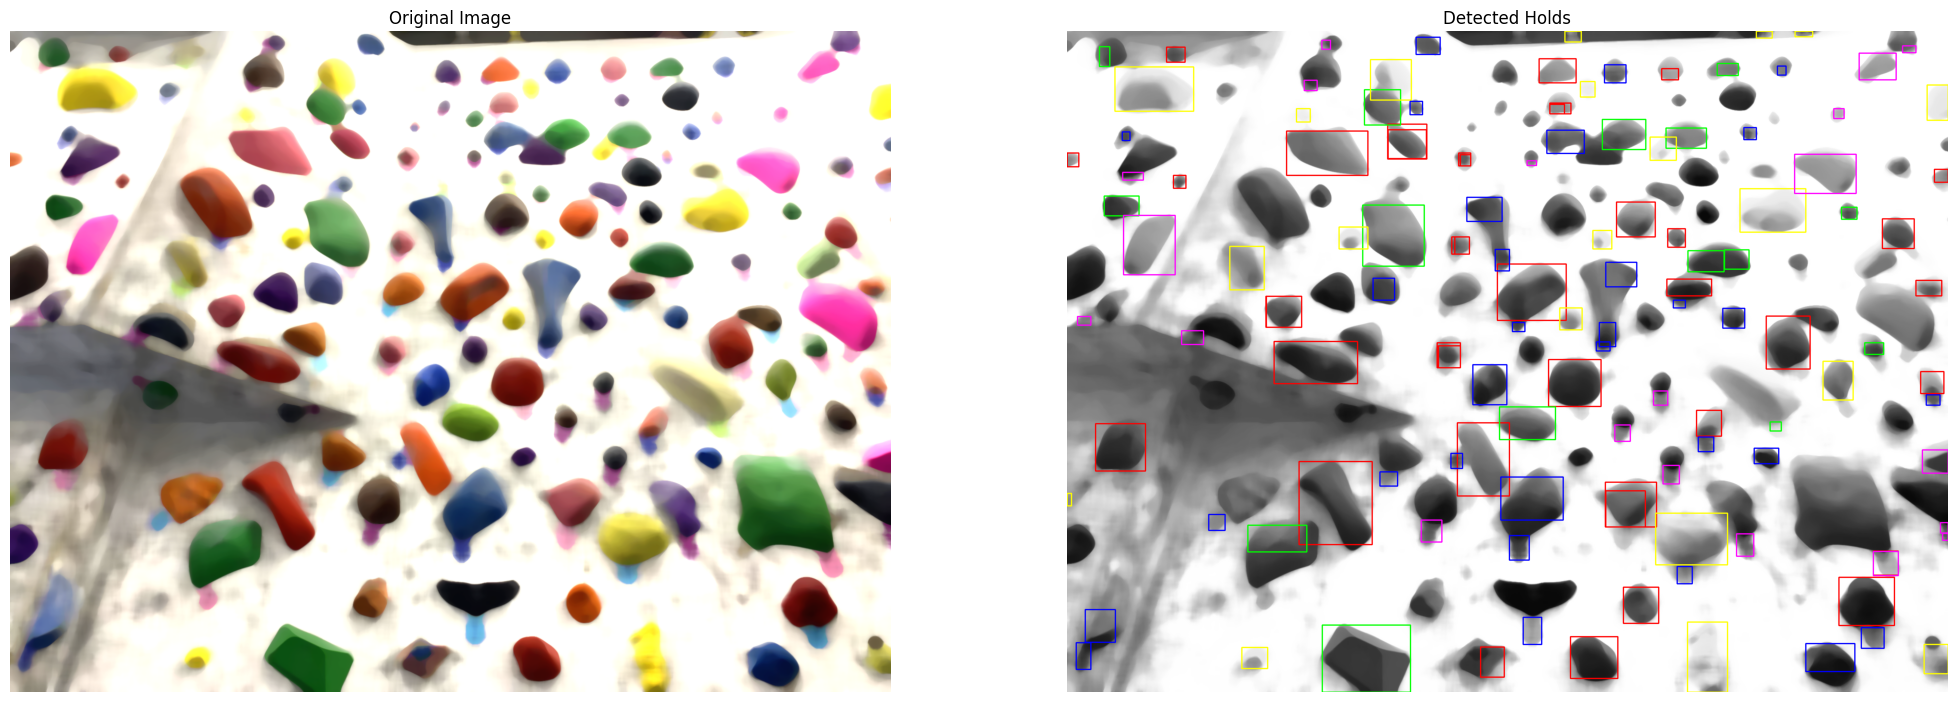

In [28]:
def draw_colored_rectangles(image, color_ranges):
    # Convert to HSV for color detection
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Convert to grayscale for final background
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Create a 3-channel version of grayscale image for colored overlays
    result = cv2.cvtColor(gray_image, cv2.COLOR_GRAY2BGR)
    
    # Define rectangle colors in BGR
    rectangle_colors = {
        'red1': (0, 0, 255),    # Red
        'red2': (0, 0, 255),    # Red
        'blue': (255, 0, 0),    # Blue
        'green': (0, 255, 0),   # Green
        'yellow': (0, 255, 255), # Yellow
        'pink': (255, 0, 255),  # Pink
    }
    
    # Process each color
    for color_name, color_range in color_ranges.items():
        if color_name == 'red1':
            # Combine both red masks
            mask1 = cv2.inRange(hsv_image, color_ranges['red1'][0], color_ranges['red1'][1])
            mask2 = cv2.inRange(hsv_image, color_ranges['red2'][0], color_ranges['red2'][1])
            mask = cv2.bitwise_or(mask1, mask2)
        else:
            lower, upper = color_range
            mask = cv2.inRange(hsv_image, lower, upper)
        
        # Find contours
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter contours based on area
        min_area = 100
        max_area = 15000
        for contour in contours:
            area = cv2.contourArea(contour)
            if min_area < area < max_area:
                # Get bounding rectangle
                x, y, w, h = cv2.boundingRect(contour)
                # Draw rectangle
                rect_color = rectangle_colors.get(color_name, (0, 0, 0))
                cv2.rectangle(result, (x, y), (x + w, y + h), rect_color, 2)
    
    return result

# Use the function
result = draw_colored_rectangles(image_blurred, color_ranges)

# Display result
plt.figure(figsize=(25, 9))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(image_blurred, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Detected Holds')
plt.show()

# Simple Color Analysis Limitations and Advanced Techniques

While the basic color thresholding approach above can detect some holds, it has several limitations:
- It relies on strict RGB/HSV thresholds which may not capture all variations of hold colors
- Different lighting conditions can significantly affect color detection (for example in this particular case holds which were near dark spots in the wall were not detected)
- Holds of similar but slightly different shades may be missed

A more sophisticated approach is to use color quantization followed by clustering. Color quantization reduces the number of distinct colors in the image by grouping similar colors together. This makes it easier to identify meaningful color clusters that correspond to climbing holds.

By applying color quantization first, we can then use clustering algorithms like K-Means to find groups of similarly colored pixels. These clusters would represent holds of the same color/route on the climbing wall. This approach is more robust as it:
- Automatically adapts to the actual colors present in the image (generalizes better to new images)
- Can handle varying lighting conditions better
- Groups similar shades together naturally
- Considers the relationships between colors in the image

Let's implement this more advanced technique next.


### Part 1: Color Quantization and K-means Clustering

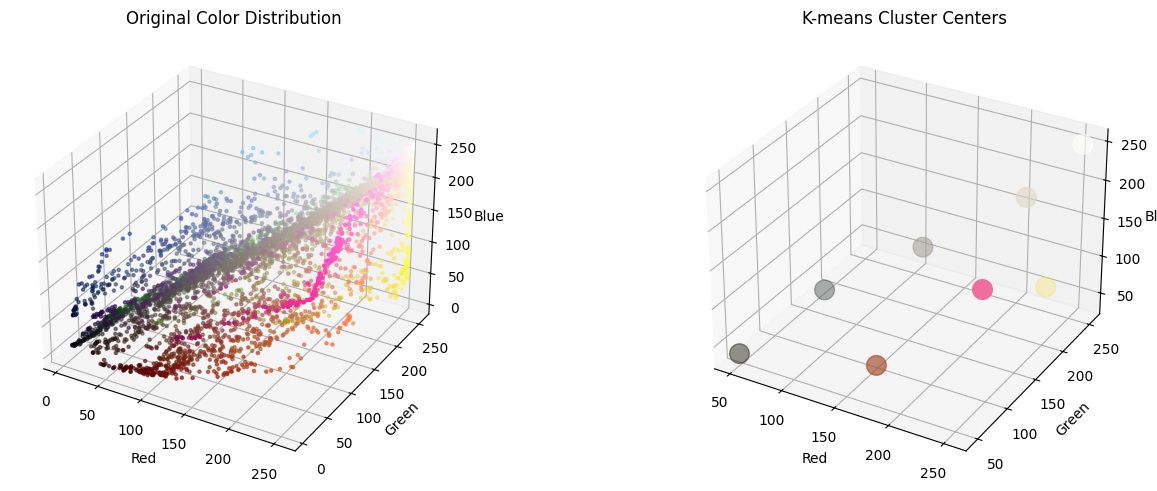

In [31]:
# Convert BGR to RGB for better color processing
image_rgb = cv2.cvtColor(image_blurred, cv2.COLOR_BGR2RGB)

# Reshape the image for color quantization
pixels = image_rgb.reshape(-1, 3)

# Convert to float32 for k-means
pixels_float = np.float32(pixels)

# Define criteria for k-means
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

# Perform k-means clustering
k = 8  # number of color clusters
_, labels, centers = cv2.kmeans(pixels_float, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

centers_clipped = np.clip(centers, 0, 255)

# Visualize the color distribution
plt.figure(figsize=(15, 5))

# 3D scatter plot of original pixels (sampling for better visualization)
sample_size = 10000
sample_indices = np.random.choice(len(pixels), sample_size, replace=False)

ax = plt.subplot(121, projection='3d')
ax.scatter(pixels[sample_indices, 0], 
          pixels[sample_indices, 1], 
          pixels[sample_indices, 2], 
          c=pixels[sample_indices]/255.0, 
          marker='.')
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('Original Color Distribution')

# 3D scatter plot of clustered centers
ax = plt.subplot(122, projection='3d')
ax.scatter(centers_clipped[:, 0], 
          centers_clipped[:, 1], 
          centers_clipped[:, 2], 
          c=centers_clipped/255.0, 
          marker='o', 
          s=200)
ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('K-means Cluster Centers')

plt.tight_layout()
plt.show()

### Part 2 - Reconstructing and Visualizing the Clustered Images:

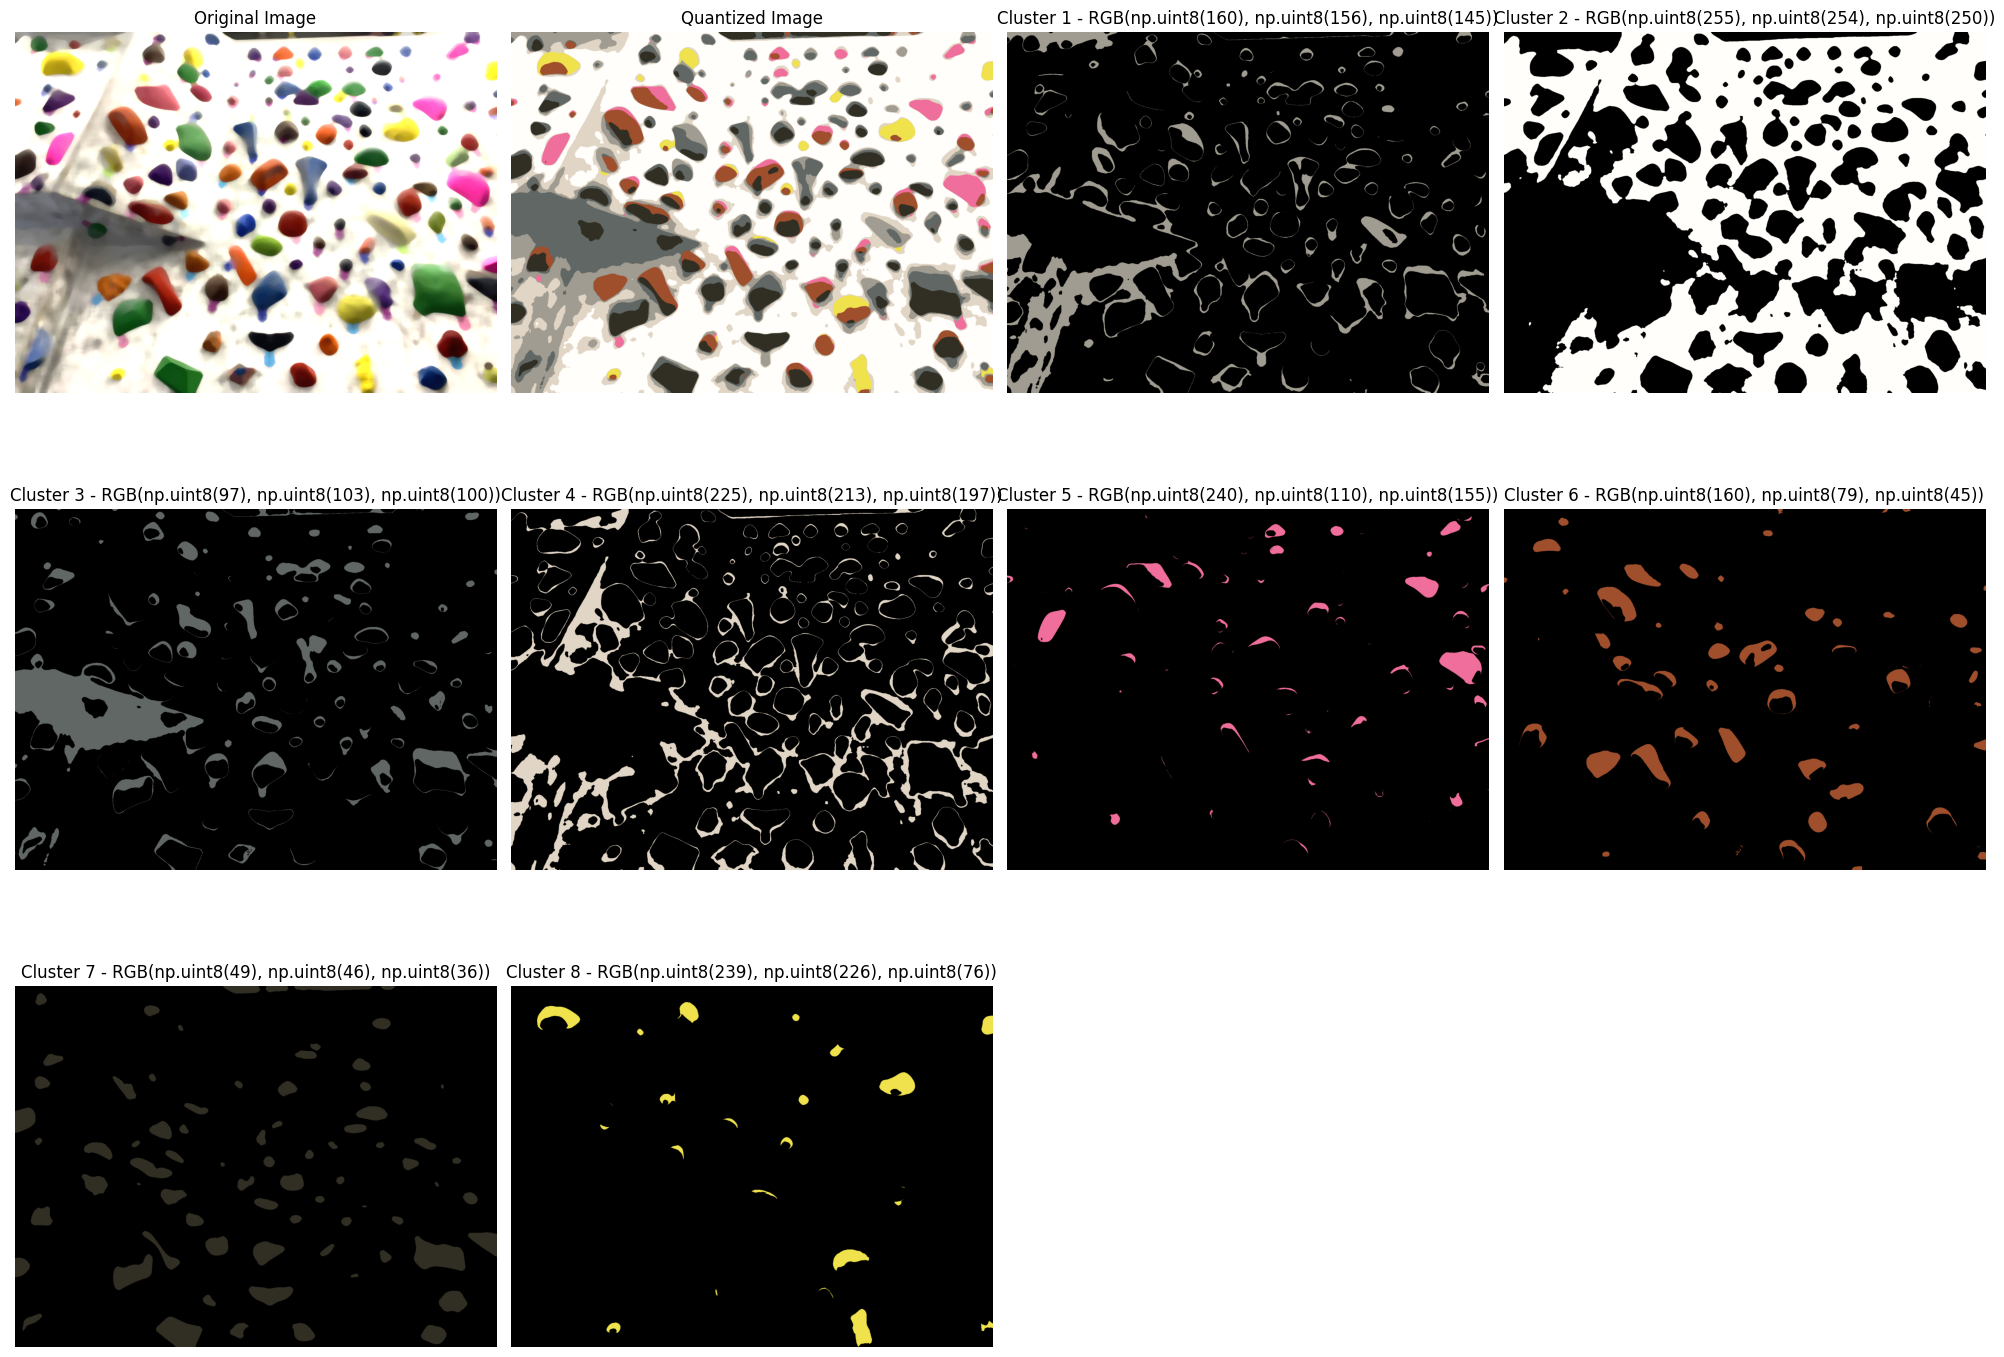

In [32]:
# Convert centers back to uint8
centers = np.uint8(centers)
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image_rgb.shape)

# Create masks for each color cluster
masks = []
for i in range(k):
    mask = np.zeros(image_grey.shape, dtype=np.uint8)
    mask[labels.reshape(image_grey.shape) == i] = 255
    masks.append(mask)

# Visualize results
plt.figure(figsize=(20, 24))

# Original image
plt.subplot(5, 4, 1)
plt.imshow(image_rgb)
plt.title('Original Image')
plt.axis('off')

# Quantized image
plt.subplot(5, 4, 2)
plt.imshow(segmented_image)
plt.title('Quantized Image')
plt.axis('off')

# Display all color cluster masks
for i in range(k):
    plt.subplot(5, 4, i + 3)
    color = centers[i]
    
    # Create colored mask by multiplying the binary mask with the cluster color
    colored_mask = np.zeros_like(image_rgb)
    colored_mask[labels.reshape(image_rgb.shape[:-1]) == i] = color
    
    plt.imshow(colored_mask)
    plt.title(f'Cluster {i+1} - RGB{tuple(color)}')
    plt.axis('off')

plt.tight_layout()
plt.show()

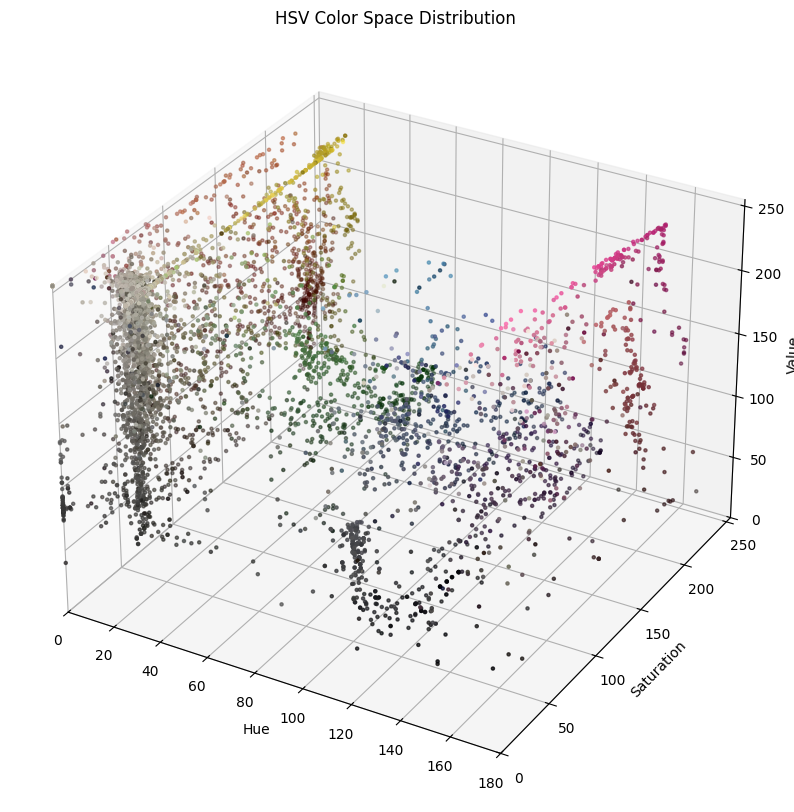

In [33]:
# Convert image to HSV
image_hsv = cv2.cvtColor(image_blurred, cv2.COLOR_BGR2HSV)

# Create figure
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Sample pixels (using fewer points for better visualization)
sample_size = 10000
pixels = image_hsv.reshape(-1, 3)
indices = np.random.choice(len(pixels), sample_size, replace=False)
sampled_pixels = pixels[indices]

# Create scatter plot
scatter = ax.scatter(sampled_pixels[:, 0],  # Hue
                    sampled_pixels[:, 1],    # Saturation
                    sampled_pixels[:, 2],    # Value
                    c=cv2.cvtColor(image, cv2.COLOR_BGR2RGB).reshape(-1, 3)[indices]/255.0,  # RGB colors
                    marker='.')

# Set labels and title
ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')
ax.set_title('HSV Color Space Distribution')

# Set axis limits
ax.set_xlim([0, 180])  # Hue range in OpenCV
ax.set_ylim([0, 255])  # Saturation range
ax.set_zlim([0, 255])  # Value range

plt.show()


Identified Color Clusters:

Cluster 1:
HSV: (26, 20, 249)
RGB: (249, 246, 229)
Percentage of image: 25.4%

Cluster 2:
HSV: (9, 216, 123)
RGB: (123, 50, 19)
Percentage of image: 4.5%

Cluster 3:
HSV: (155, 111, 220)
RGB: (220, 124, 204)
Percentage of image: 4.7%

Cluster 4:
HSV: (100, 176, 81)
RGB: (25, 62, 81)
Percentage of image: 4.6%

Cluster 5:
HSV: (0, 0, 255)
RGB: (255, 255, 255)
Percentage of image: 31.4%

Cluster 6:
HSV: (21, 37, 185)
RGB: (185, 177, 158)
Percentage of image: 9.9%

Cluster 7:
HSV: (124, 48, 114)
RGB: (95, 93, 114)
Percentage of image: 5.5%

Cluster 8:
HSV: (40, 118, 129)
RGB: (109, 129, 69)
Percentage of image: 4.5%

Cluster 9:
HSV: (19, 166, 226)
RGB: (226, 172, 79)
Percentage of image: 3.8%

Cluster 10:
HSV: (17, 26, 103)
RGB: (103, 98, 92)
Percentage of image: 5.8%


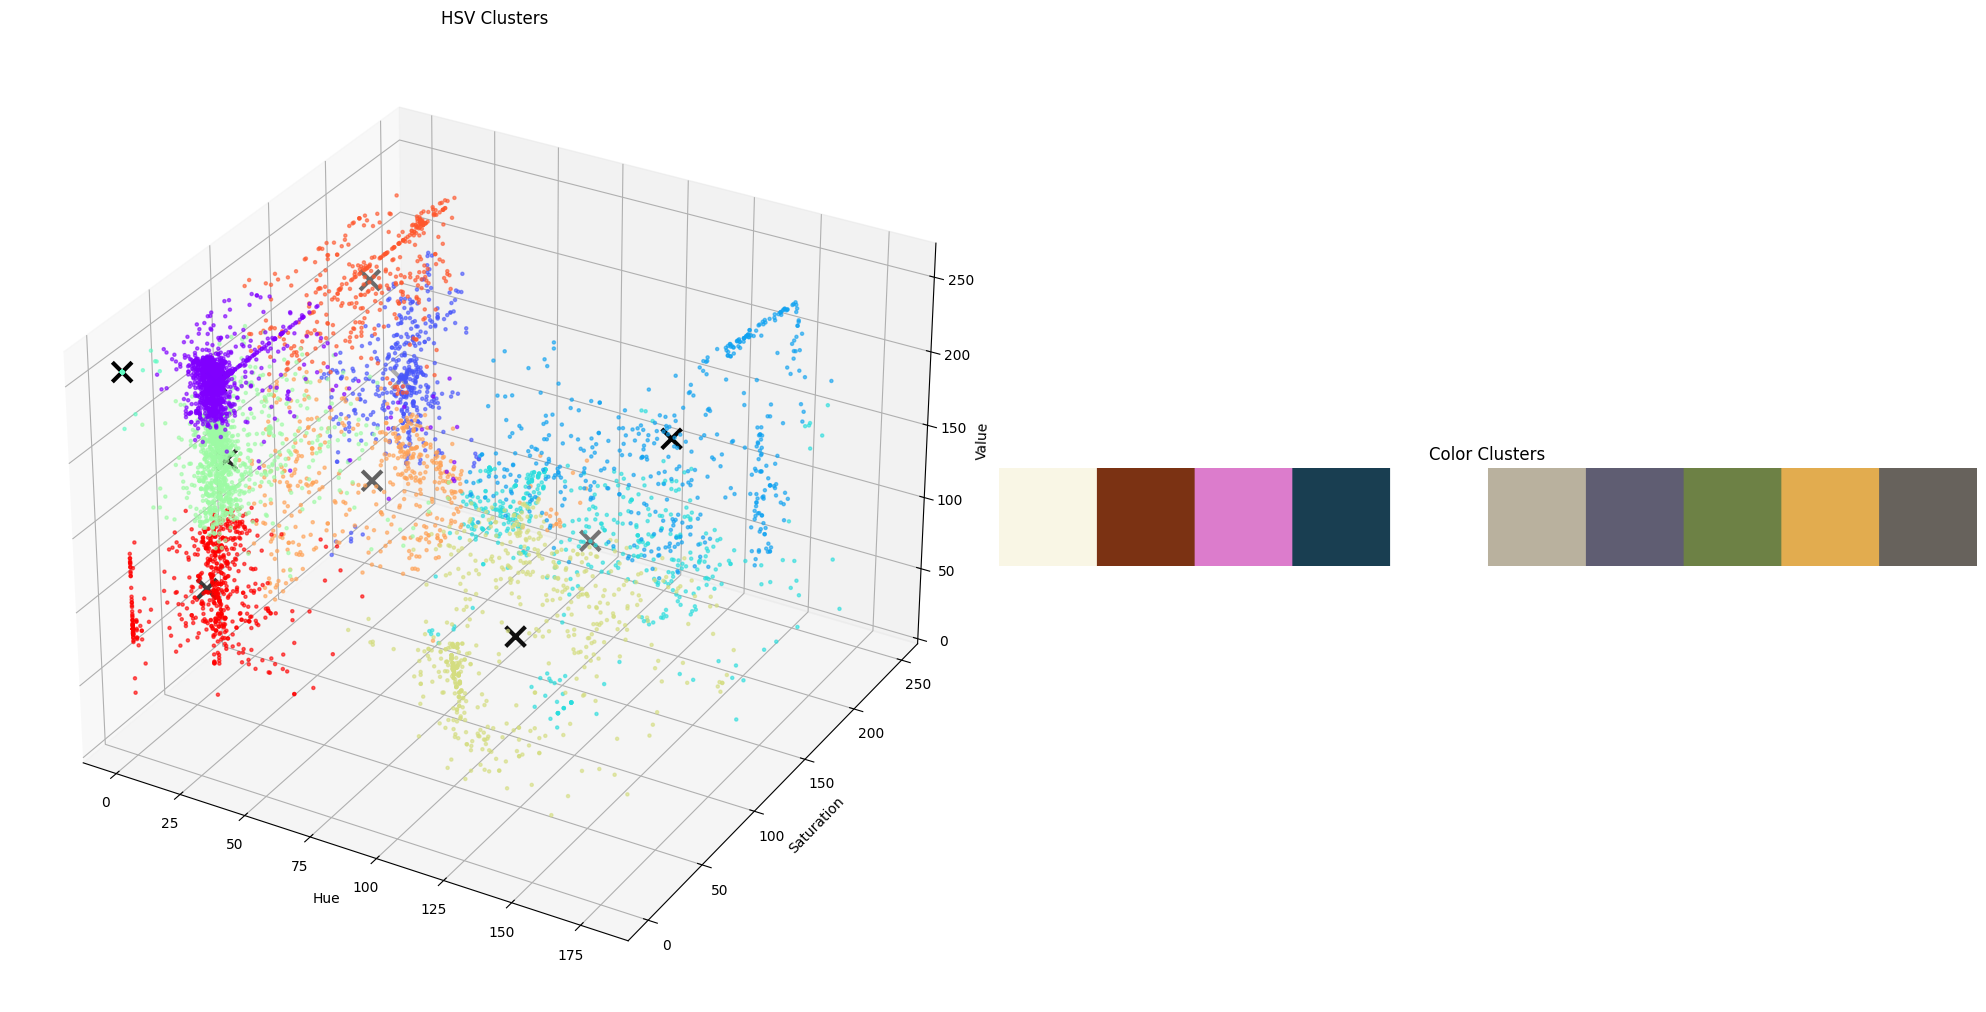

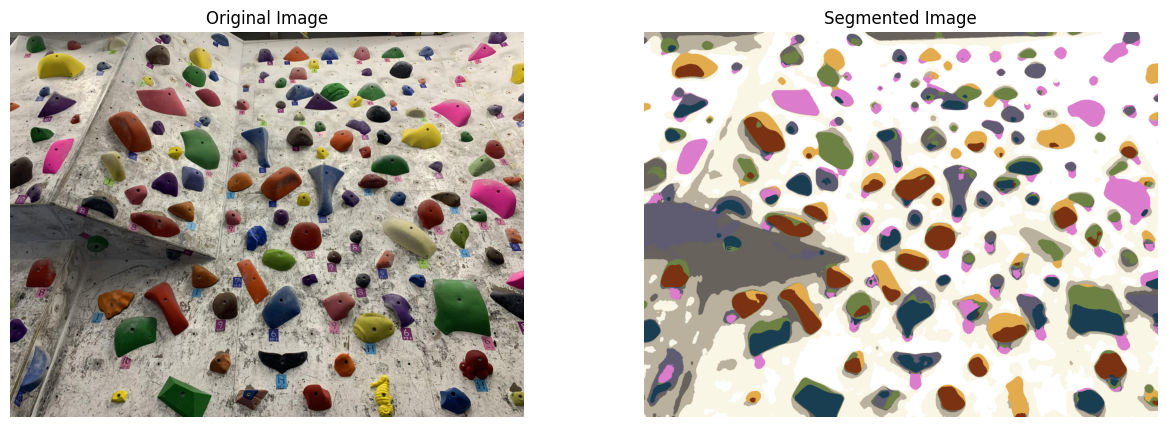

In [34]:
# Convert to HSV and reshape for clustering
image_hsv = cv2.cvtColor(image_blurred, cv2.COLOR_BGR2HSV)
pixels_hsv = image_hsv.reshape(-1, 3)

# Convert to float32 for k-means
pixels_float = np.float32(pixels_hsv)

# Perform k-means clustering
k = 10  # adjust based on expected number of hold colors
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
_, labels, centers = cv2.kmeans(pixels_float, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

# Convert centers back to uint8
centers = np.uint8(centers)

# Create visualization
plt.figure(figsize=(20, 10))

# 3D scatter plot of clusters
ax = plt.subplot(121, projection='3d')
sample_size = 10000
indices = np.random.choice(len(pixels_hsv), sample_size, replace=False)

# Plot sampled points
scatter = ax.scatter(pixels_hsv[indices, 0],
                    pixels_hsv[indices, 1],
                    pixels_hsv[indices, 2],
                    c=labels[indices],
                    cmap='rainbow',
                    marker='.',
                    alpha=0.6)

# Plot cluster centers
ax.scatter(centers[:, 0],
          centers[:, 1],
          centers[:, 2],
          c='black',
          marker='x',
          s=200,
          linewidths=3)

ax.set_xlabel('Hue')
ax.set_ylabel('Saturation')
ax.set_zlabel('Value')
ax.set_title('HSV Clusters')

# Display color swatches for each cluster
plt.subplot(122)
color_swatches = np.zeros((100, k*100, 3), dtype=np.uint8)

# Convert cluster centers back to RGB for visualization
centers_rgb = cv2.cvtColor(centers.reshape(-1, 1, 3), cv2.COLOR_HSV2RGB)

# Print cluster information and create color swatches
print("\nIdentified Color Clusters:")
for i in range(k):
    # Create color swatch
    color_swatches[:, i*100:(i+1)*100] = centers_rgb[i]
    
    # Calculate percentage of pixels in this cluster
    cluster_size = np.count_nonzero(labels == i)
    percentage = (cluster_size / len(labels)) * 100
    
    # Print cluster information
    hsv_values = centers[i]
    rgb_values = centers_rgb[i][0]
    print(f"\nCluster {i+1}:")
    print(f"HSV: ({hsv_values[0]}, {hsv_values[1]}, {hsv_values[2]})")
    print(f"RGB: ({rgb_values[0]}, {rgb_values[1]}, {rgb_values[2]})")
    print(f"Percentage of image: {percentage:.1f}%")

plt.imshow(color_swatches)
plt.title('Color Clusters')
plt.axis('off')

plt.tight_layout()
plt.show()

# Create segmented image based on clusters
segmented_image = centers[labels.flatten()]
segmented_image = segmented_image.reshape(image_hsv.shape)
segmented_rgb = cv2.cvtColor(segmented_image, cv2.COLOR_HSV2RGB)

# Display original vs segmented
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(segmented_rgb)
plt.title('Segmented Image')
plt.axis('off')

plt.show()